In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random
import csv
from PIL import Image
import shutil
from tqdm import tqdm
import torch
# ssim
from skimage.metrics import structural_similarity as ssim

from utils.utils0 import tensor_affine_transform, transform_to_displacement_field
from utils.utils1 import transform_points_DVF, ModelParams
from utils.SuperPoint import SuperPointFrontend, PointTracker
from utils.datagen import datagen

nn_thresh = 0.7
superpoint = SuperPointFrontend('utils/superpoint_v1.pth', nms_dist=4,
                          conf_thresh=0.015, nn_thresh=nn_thresh, cuda=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the data
data = pd.read_csv('Dataset/dataset_eye_actual_full.csv')


In [147]:
# take data with 'training' = 0
data = data[data['training'] == 0].reset_index(drop=True)

In [148]:
data.head()

,Unnamed: 0,source,Source ROI,target,Target ROI,training,Warped target images,Warped target ROI,Execution time,Directory
0,9,Dataset/Dataset-processed/15-12-2559/2011248/R...,NaN,Dataset/Dataset-processed/15-12-2559/2011248/R...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Rc
1,10,Dataset/Dataset-processed/15-12-2559/2011248/R...,NaN,Dataset/Dataset-processed/15-12-2559/2011248/R...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Rc
2,11,Dataset/Dataset-processed/15-12-2559/2011248/R...,NaN,Dataset/Dataset-processed/15-12-2559/2011248/R...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Rc
3,12,Dataset/Dataset-processed/15-12-2559/2976988-1...,NaN,Dataset/Dataset-processed/15-12-2559/2976988-1...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2976988-16/b
4,13,Dataset/Dataset-processed/15-12-2559/2976988-1...,NaN,Dataset/Dataset-processed/15-12-2559/2976988-1...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2976988-16/b


In [149]:
data.shape

(763, 10)

In [150]:
# add columns 'keypoints', 'mse', 'tre'
data['keypoints'] = 0
data['no_keypoints'] = 0
data['mse'] = 0
data['ssim'] = 0
data['tre'] = 0
# keypoints_path = []

# calculate the keypoints, mse, tre
for i in range(data.shape[0]):
    # keypoints = 0
    # mse = 0
    # tre = 0
    # read image file from column 'source' and 'target'
    source = cv2.imread(data['source'].iloc[i], 0)
    target = cv2.imread(data['target'].iloc[i], 0)
    source = cv2.resize(source, (256, 256), interpolation=cv2.INTER_AREA)
    target = cv2.resize(target, (256, 256), interpolation=cv2.INTER_AREA)
    source = (source / np.max(source)).astype(np.float32)
    target = (target / np.max(target)).astype(np.float32)

    points1, desc1, heatmap1 = superpoint(source)
    points2, desc2, heatmap2 = superpoint(target)

    tracker = PointTracker(5, nn_thresh=0.7)
    try:
        matches = tracker.nn_match_two_way(desc1, desc2, nn_thresh=nn_thresh)
    except:
        print('No matches found')
        # TODO: find a better way to do this
        pass

    matches1 = np.array(points1[:2, matches[0, :].astype(int)])
    matches2 = np.array(points2[:2, matches[1, :].astype(int)])

    df = pd.DataFrame({'x1': matches1[0, :], 'y1': matches1[1, :],
                       'x2': matches2[0, :], 'y2': matches2[1, :]})
    save_name = 'Dataset/eye_keypoints_test/' + f'img_{i}.csv'

    df.to_csv(save_name, index=False)

    # calculate MSE
    mse = np.mean((source - target) ** 2)
    # calculate ssim
    ssim_ = ssim(source, target, data_range=target.max() - target.min())
    # calculate TRE
    tre = np.sqrt(np.sum((matches1 - matches2) ** 2))

    # save keypoints, mse, tre to the dataframe
    data['keypoints'][i] = save_name
    data['no_keypoints'][i] = matches1.shape[1]
    data['ssim'][i] = ssim_
    data['mse'][i] = mse
    data['tre'][i] = tre

data.head()
# print(data.shape)

/tmp/ipykernel_522827/3542570842.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['keypoints'][i] = save_name
/tmp/ipykernel_522827/3542570842.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Dataset/eye_keypoints_test/img_0.csv' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data['keypoints'][i] = save_name
/tmp/ipykernel_522827/3542570842.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['no_keypoints'][i] = matches1.shape[1]
/tmp/ipykernel_522827/3542570842.py:52: SettingWithCopyWarn

,Unnamed: 0,source,Source ROI,target,Target ROI,training,Warped target images,Warped target ROI,Execution time,Directory,keypoints,no_keypoints,mse,ssim,tre
0,9,Dataset/Dataset-processed/15-12-2559/2011248/R...,NaN,Dataset/Dataset-processed/15-12-2559/2011248/R...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Rc,Dataset/eye_keypoints_test/img_0.csv,113,0.016657,0.378623,121.412520
1,10,Dataset/Dataset-processed/15-12-2559/2011248/R...,NaN,Dataset/Dataset-processed/15-12-2559/2011248/R...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Rc,Dataset/eye_keypoints_test/img_1.csv,99,0.023900,0.362167,129.761319
2,11,Dataset/Dataset-processed/15-12-2559/2011248/R...,NaN,Dataset/Dataset-processed/15-12-2559/2011248/R...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Rc,Dataset/eye_keypoints_test/img_2.csv,113,0.019042,0.377975,135.642914
3,12,Dataset/Dataset-processed/15-12-2559/2976988-1...,NaN,Dataset/Dataset-processed/15-12-2559/2976988-1...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2976988-16/b,Dataset/eye_keypoints_test/img_3.csv,56,0.009689,0.525158,81.252692
4,13,Dataset/Dataset-processed/15-12-2559/2976988-1...,NaN,Dataset/Dataset-processed/15-12-2559/2976988-1...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2976988-16/b,Dataset/eye_keypoints_test/img_4.csv,75,0.015547,0.475048,117.392504


In [151]:
# save the dataframe to csv
# data.to_csv('dataset_eye.csv', index=False)

In [152]:
# drop the rows with mse < 0.01
data_cut = data[data['mse'] > 0.01]

In [153]:
data.shape

(763, 15)

In [154]:
data_cut.shape

(673, 15)

In [155]:
mse = data['mse']
tre = data['tre']
kp = data['no_keypoints']
ssim_ = data['ssim']

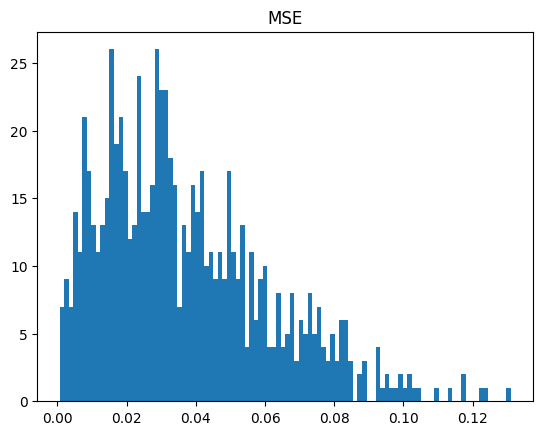

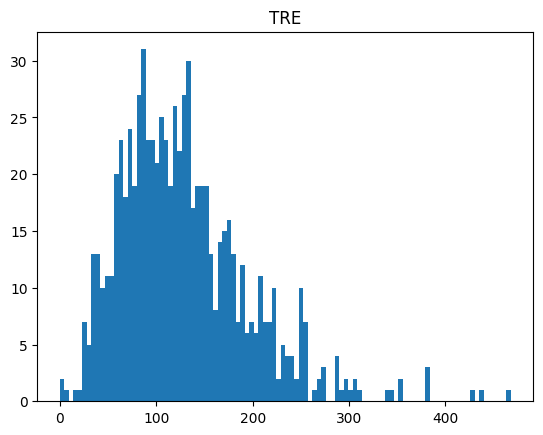

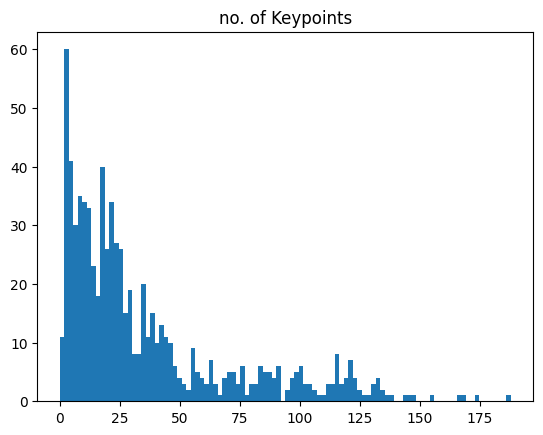

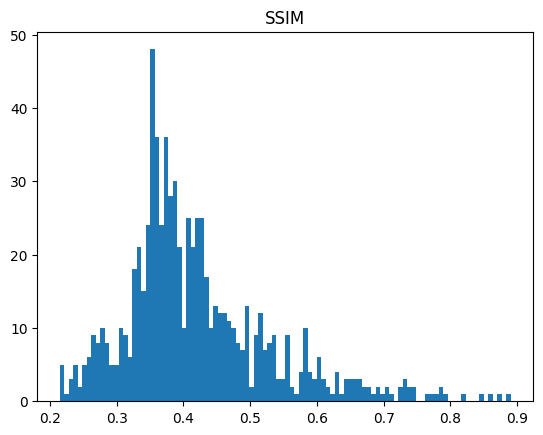

In [156]:
plt.hist(mse, bins=100)
plt.title('MSE')
plt.show()

plt.hist(tre, bins=100)
plt.title('TRE')
plt.show()

plt.hist(kp, bins=100)
plt.title('no. of Keypoints')
plt.show()

plt.hist(ssim_, bins=100)
plt.title('SSIM')
plt.show()

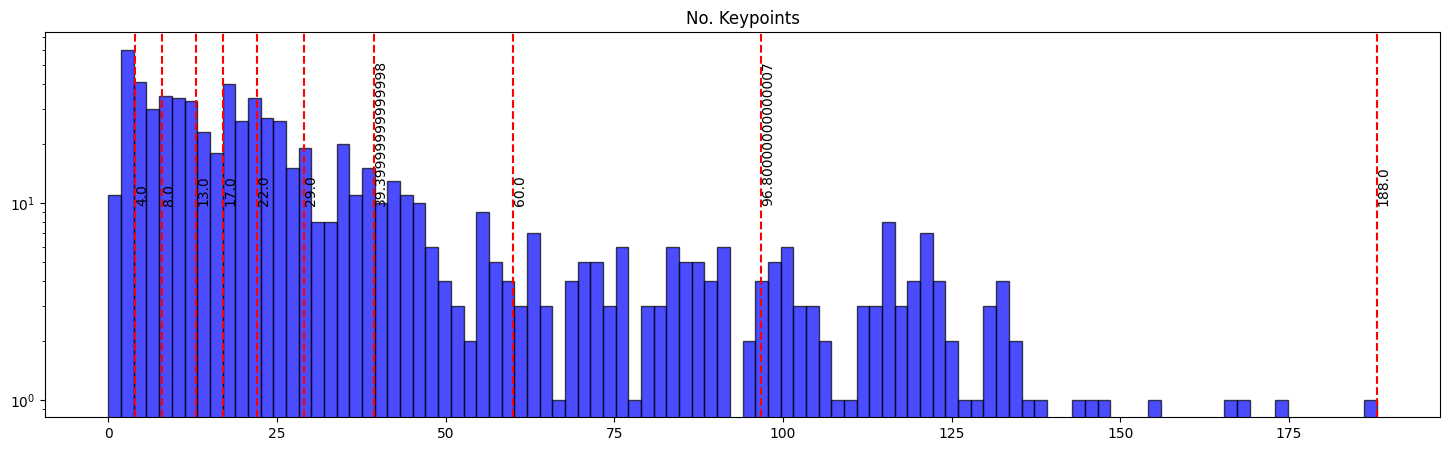

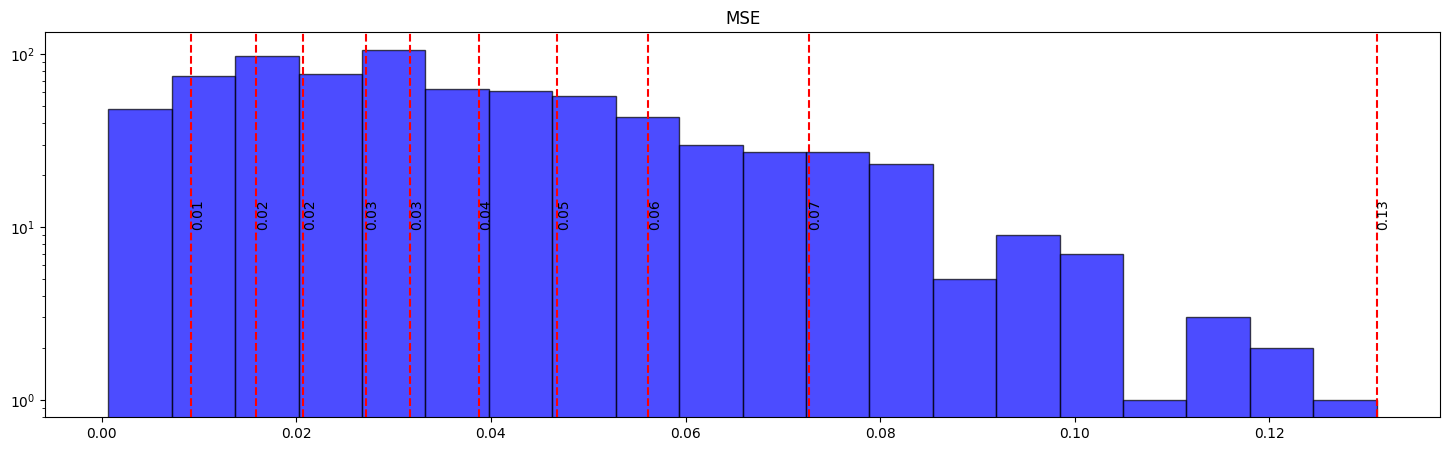

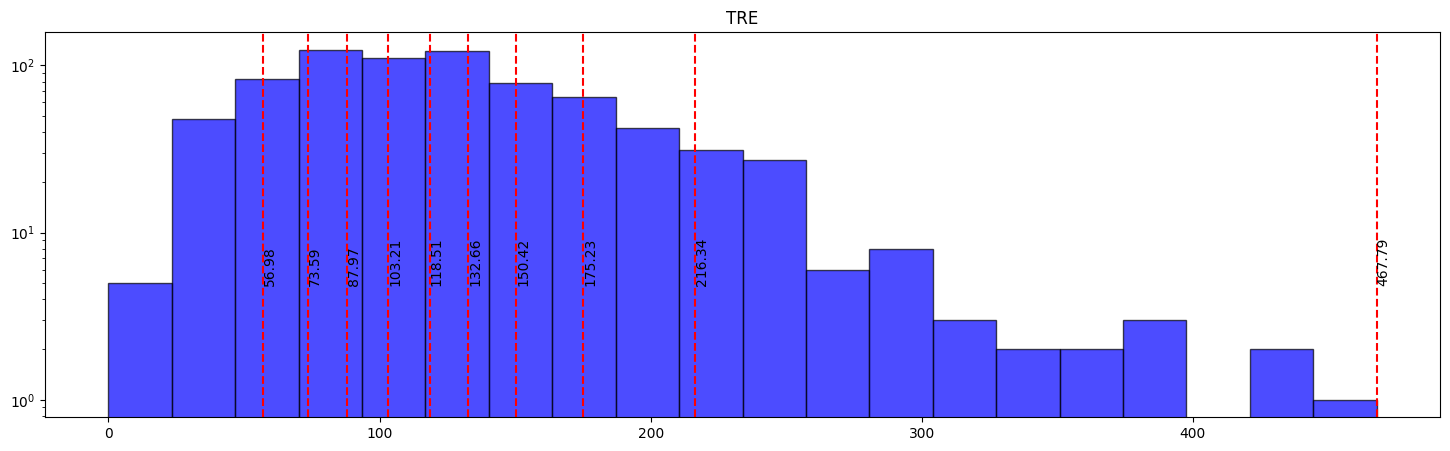

In [157]:
# show histogram with different colors for each 10% of mse, tre

kp_10 = np.percentile(kp, np.arange(0, 101, 10))
mse_10 = np.percentile(mse, np.arange(0, 101, 10))
tre_10 = np.percentile(tre, np.arange(0, 101, 10))

plt.figure(figsize=(18, 5))
plt.hist(kp, bins=100, color='blue', alpha=0.7, edgecolor='black')
for i in range(1, len(kp_10)):
    plt.axvline(kp_10[i], color='red', linestyle='dashed')
    plt.text(kp_10[i], 10, str(kp_10[i]), rotation=90)
plt.title('No. Keypoints')
plt.yscale('log')
plt.show()

# show histogram with different colors for each 10% of mse, tre
plt.figure(figsize=(18, 5))
plt.hist(mse, bins=20, color='blue', alpha=0.7, edgecolor='black')

for i in range(1, len(mse_10)):
    plt.axvline(mse_10[i], color='red', linestyle='dashed')
    plt.text(mse_10[i], 10, str(round(mse_10[i], 2)), rotation=90)
plt.title('MSE')
plt.yscale('log')
plt.show()

plt.figure(figsize=(18, 5))
plt.hist(tre, bins=20, color='blue', alpha=0.7, edgecolor='black')
for i in range(1, len(tre_10)):
    plt.axvline(tre_10[i], color='red', linestyle='dashed')
    plt.text(tre_10[i], 5, str(round(tre_10[i], 2)), rotation=90)
plt.yscale('log')
plt.title('TRE')
plt.show()


In [158]:
# get the value of mse, tre for each 10% of mse, tre
mse_10 = np.percentile(mse, np.arange(0, 101, 10))
tre_10 = np.percentile(tre, np.arange(0, 101, 10))

mse_10 = np.round(mse_10, 4)
tre_10 = np.round(tre_10, 4)

for i in range(len(mse_10) - 1):
    print(f'Percentile {i+1}: {mse_10[i]} - {mse_10[i+1]}, {tre_10[i]} - {tre_10[i+1]}')

Percentile 1: 0.0007 - 0.0092, 0.0 - 56.9818
Percentile 2: 0.0092 - 0.0159, 56.9818 - 73.5894
Percentile 3: 0.0159 - 0.0207, 73.5894 - 87.9659
Percentile 4: 0.0207 - 0.0271, 87.9659 - 103.2143
Percentile 5: 0.0271 - 0.0317, 103.2143 - 118.5116
Percentile 6: 0.0317 - 0.0388, 118.5116 - 132.6648
Percentile 7: 0.0388 - 0.0468, 132.6648 - 150.4241
Percentile 8: 0.0468 - 0.0562, 150.4241 - 175.2335
Percentile 9: 0.0562 - 0.0727, 175.2335 - 216.3423
Percentile 10: 0.0727 - 0.131, 216.3423 - 467.7884


In [159]:
# percentile 30 and 70
mse_30 = np.percentile(mse, 30)
mse_70 = np.percentile(mse, 70)
tre_30 = np.percentile(tre, 30)
tre_70 = np.percentile(tre, 70)

print(f'Percentile 30: {mse_30}, {tre_30}')
print(f'Percentile 70: {mse_70}, {tre_70}')


Percentile 30: 0.020732348412275316, 87.96590248499699
Percentile 70: 0.046763763576745984, 150.42406496709546


In [160]:
# sort data by 'mse' and reset index
# data = data.sort_values(by='mse').reset_index(drop=True)
data

,Unnamed: 0,source,Source ROI,target,Target ROI,training,Warped target images,Warped target ROI,Execution time,Directory,keypoints,no_keypoints,mse,ssim,tre
0,9,Dataset/Dataset-processed/15-12-2559/2011248/R...,NaN,Dataset/Dataset-processed/15-12-2559/2011248/R...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Rc,Dataset/eye_keypoints_test/img_0.csv,113,0.016657,0.378623,121.412520
1,10,Dataset/Dataset-processed/15-12-2559/2011248/R...,NaN,Dataset/Dataset-processed/15-12-2559/2011248/R...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Rc,Dataset/eye_keypoints_test/img_1.csv,99,0.023900,0.362167,129.761319
2,11,Dataset/Dataset-processed/15-12-2559/2011248/R...,NaN,Dataset/Dataset-processed/15-12-2559/2011248/R...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2011248/Rc,Dataset/eye_keypoints_test/img_2.csv,113,0.019042,0.377975,135.642914
3,12,Dataset/Dataset-processed/15-12-2559/2976988-1...,NaN,Dataset/Dataset-processed/15-12-2559/2976988-1...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2976988-16/b,Dataset/eye_keypoints_test/img_3.csv,56,0.009689,0.525158,81.252692
4,13,Dataset/Dataset-processed/15-12-2559/2976988-1...,NaN,Dataset/Dataset-processed/15-12-2559/2976988-1...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/15-12-2559/2976988-16/b,Dataset/eye_keypoints_test/img_4.csv,75,0.015547,0.475048,117.392504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,4584,Dataset/Dataset-processed/28-04-2560/3797814-R...,NaN,Dataset/Dataset-processed/28-04-2560/3797814-R...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/28-04-2560/3797814-R/b,Dataset/eye_keypoints_test/img_758.csv,6,0.092576,0.288312,122.347865
759,4585,Dataset/Dataset-processed/28-04-2560/3797814-R...,NaN,Dataset/Dataset-processed/28-04-2560/3797814-R...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/28-04-2560/3797814-R/b,Dataset/eye_keypoints_test/img_759.csv,22,0.072963,0.302921,223.883898
760,4586,Dataset/Dataset-processed/28-04-2560/3797814-R...,NaN,Dataset/Dataset-processed/28-04-2560/3797814-R...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/28-04-2560/3797814-R/b,Dataset/eye_keypoints_test/img_760.csv,96,0.013989,0.492403,78.809898
761,4587,Dataset/Dataset-processed/28-04-2560/3797814-R...,NaN,Dataset/Dataset-processed/28-04-2560/3797814-R...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/28-04-2560/3797814-R/b,Dataset/eye_keypoints_test/img_761.csv,27,0.039490,0.362778,73.532306


# sort image pair difficulty by number of matched keypoint pairs

In [161]:
# sort kp from smallest to largest
data = data.sort_values(by='no_keypoints').reset_index(drop=True)
# delete the column Unnamed: 0
data = data.drop(columns='Unnamed: 0')
data

,source,Source ROI,target,Target ROI,training,Warped target images,Warped target ROI,Execution time,Directory,keypoints,no_keypoints,mse,ssim,tre
0,Dataset/Dataset-processed/03-03-2560/1387253-1...,NaN,Dataset/Dataset-processed/03-03-2560/1387253-1...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/03-03-2560/1387253-1R/b,Dataset/eye_keypoints_test/img_111.csv,0,0.095725,0.235382,0.000000
1,Dataset/Dataset-processed/28-04-2560/3798159-R...,NaN,Dataset/Dataset-processed/28-04-2560/3798159-R...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/28-04-2560/3798159-R/b,Dataset/eye_keypoints_test/img_654.csv,0,0.030287,0.343356,0.000000
2,Dataset/Dataset-processed/23-12-2559/3691745/b...,NaN,Dataset/Dataset-processed/23-12-2559/3691745/b...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/23-12-2559/3691745/b1,Dataset/eye_keypoints_test/img_185.csv,1,0.044223,0.284027,38.897301
3,Dataset/Dataset-processed/03-03-2560/1387253-1...,NaN,Dataset/Dataset-processed/03-03-2560/1387253-1...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/03-03-2560/1387253-1R/b,Dataset/eye_keypoints_test/img_91.csv,1,0.100782,0.238905,80.622577
4,Dataset/Dataset-processed/17-03-2560/3788391-1...,NaN,Dataset/Dataset-processed/17-03-2560/3788391-1...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/17-03-2560/3788391-1...,Dataset/eye_keypoints_test/img_548.csv,1,0.063832,0.353985,54.744863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,Dataset/Dataset-processed/06-01-2560/3680074-2...,NaN,Dataset/Dataset-processed/06-01-2560/3680074-2...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/06-01-2560/3680074-2/b,Dataset/eye_keypoints_test/img_575.csv,156,0.014839,0.375616,111.700492
759,Dataset/Dataset-processed/23-12-2559/2323956/b...,NaN,Dataset/Dataset-processed/23-12-2559/2323956/b...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/23-12-2559/2323956/b1,Dataset/eye_keypoints_test/img_235.csv,167,0.002350,0.714374,35.860842
760,Dataset/Dataset-processed/23-12-2559/2323956/b...,NaN,Dataset/Dataset-processed/23-12-2559/2323956/b...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/23-12-2559/2323956/b1,Dataset/eye_keypoints_test/img_240.csv,169,0.004428,0.586307,72.587878
761,Dataset/Dataset-processed/23-12-2559/2323956/b...,NaN,Dataset/Dataset-processed/23-12-2559/2323956/b...,NaN,0,NaN,NaN,NaN,Dataset/Dataset-processed/23-12-2559/2323956/b1,Dataset/eye_keypoints_test/img_233.csv,173,0.006718,0.563710,101.548018


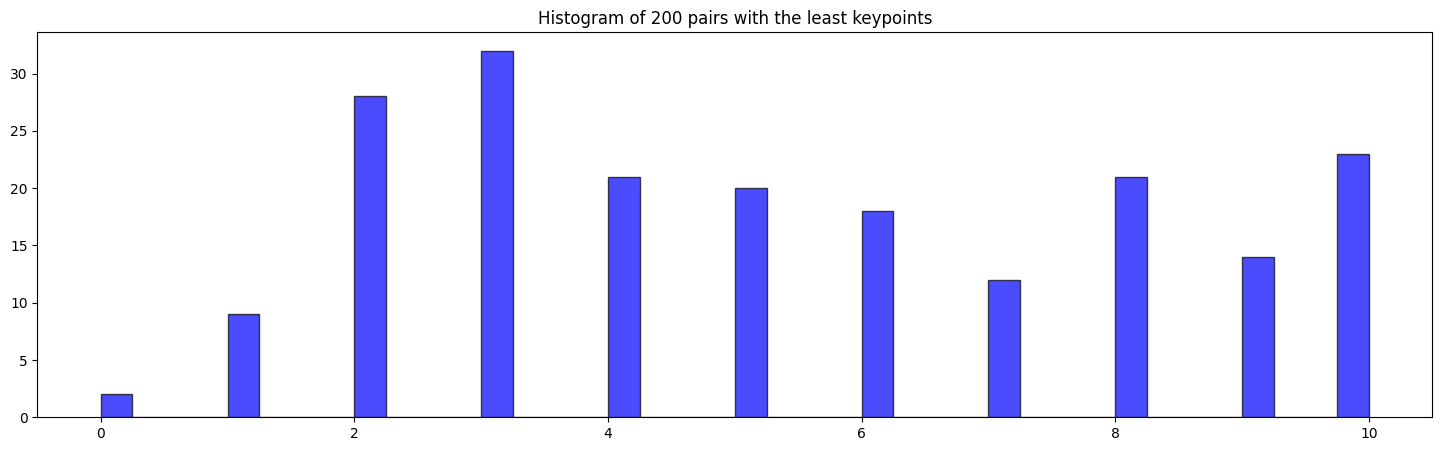

In [162]:
# histogram of 200 pairs with the least keypoints
plt.figure(figsize=(18, 5))
plt.hist(data['no_keypoints'][:200], bins=40, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histogram of 200 pairs with the least keypoints')
plt.show()

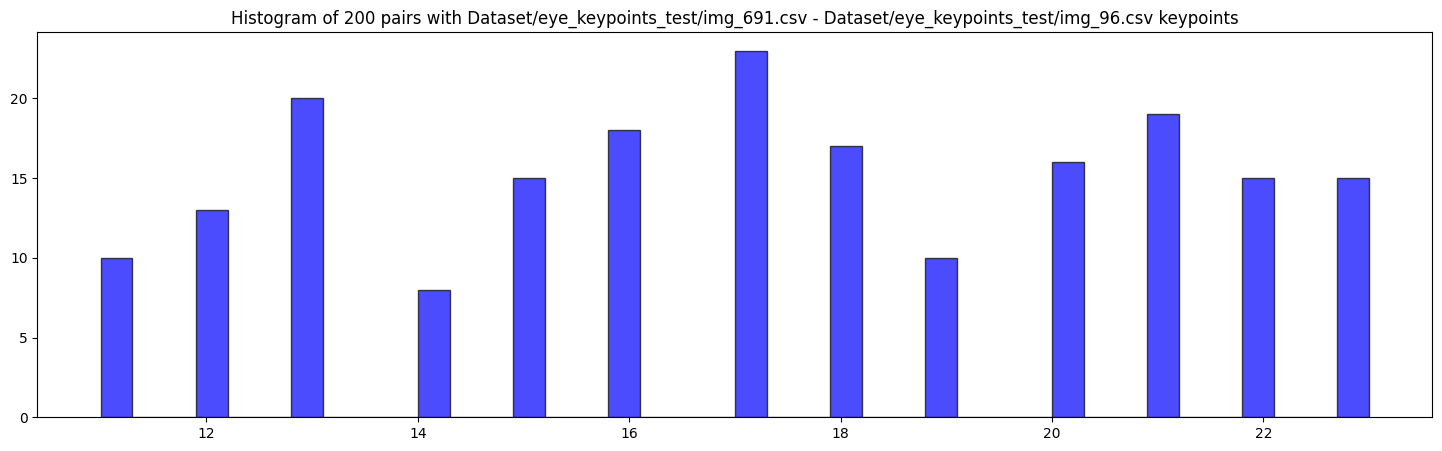

In [163]:
# histogram of 200 pairs with 201-400 keypoints
plt.figure(figsize=(18, 5))
start = 201
plt.hist(data['no_keypoints'][start:400], bins=40, color='blue', alpha=0.7, edgecolor='black')
plt.title(f"Histogram of 200 pairs with {data['keypoints'][start]} - {data['keypoints'][400]} keypoints")
plt.show()

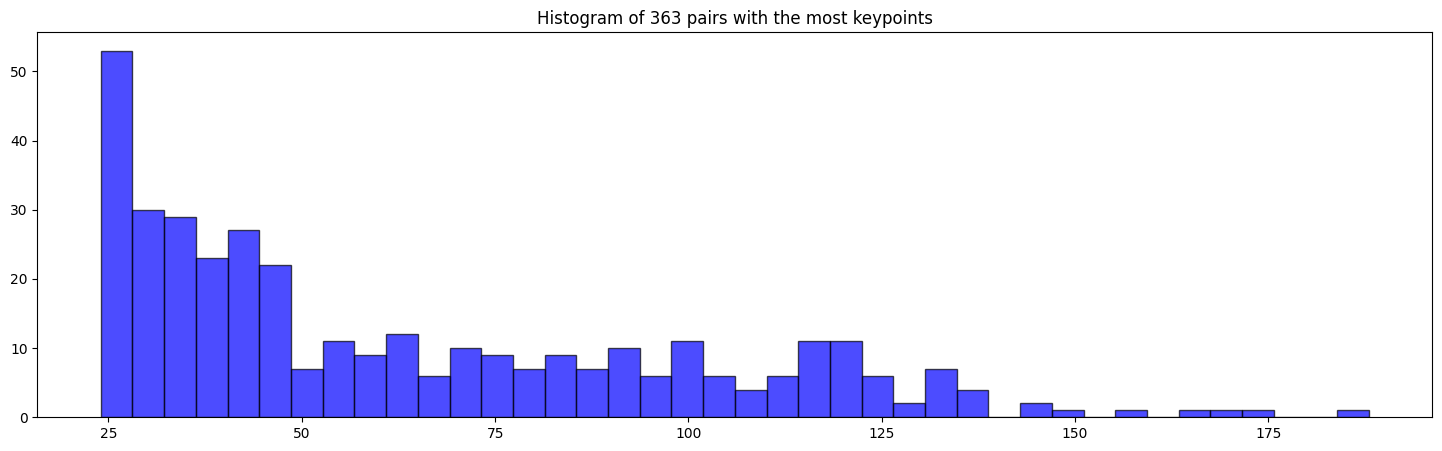

In [164]:
# histogram of 200 pairs with the most keypoints
plt.figure(figsize=(18, 5))
plt.hist(data['no_keypoints'][400:], bins=40, color='blue', alpha=0.7, edgecolor='black')
plt.title(f"Histogram of {data.shape[0]-400} pairs with the most keypoints")
plt.show()

In [165]:
# save the dataframe to csv
# row 0 - 200: hard dataset
data[:200].to_csv('Dataset/dataset_eye_hard.csv', index=False)

# row 201 - 400: medium dataset
data[201:400].to_csv('Dataset/dataset_eye_medium.csv', index=False)

# row 401 - end: easy dataset
data[401:].to_csv('Dataset/dataset_eye_easy.csv', index=False)